# Paper 1: "The Unreasonable Effectiveness of Data"
## Autoren: Katrin Nguyen & Nico Loss

## Import & Settings

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import kagglehub
from ydata_profiling import ProfileReport

from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline

# --- Settings for Reproducibility and Visualization ---
# Set random seed for all operations to be reproducible
np.random.seed(42)

%matplotlib inline

# Plot settings for better aesthetics
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 7)

## Data Loading
Download Dataset from Kaggle.com: https://www.kaggle.com/datasets/shivam2503/diamonds

In [44]:
path = kagglehub.dataset_download("shivam2503/diamonds")

print("Path to dataset files:", path)

df = pd.read_csv(path + "\\diamonds.csv")

df.drop(columns=["Unnamed: 0"], inplace=True) # Fehlerhafte Index Column entfernen


Path to dataset files: C:\Users\nicol\.cache\kagglehub\datasets\shivam2503\diamonds\versions\1


## Peak into Dataset and first exploration

In [45]:
print("#--- Dataset Information ---#")
df.info()

print("\n#--- First 5 Rows ---#")
print(df.head())

print("\n#--- Descriptive Statistics ---#")
print(df.describe())

# Check for Zero values in dimension
print(f"\nRows with zero dimensions (x, y, or z): {df[(df['x']==0) | (df['y']==0) | (df['z']==0)].shape[0]}")

#--- Dataset Information ---#
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB

#--- First 5 Rows ---#
   carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I     VS2   6

## VISUALIZATIONS of Dataset

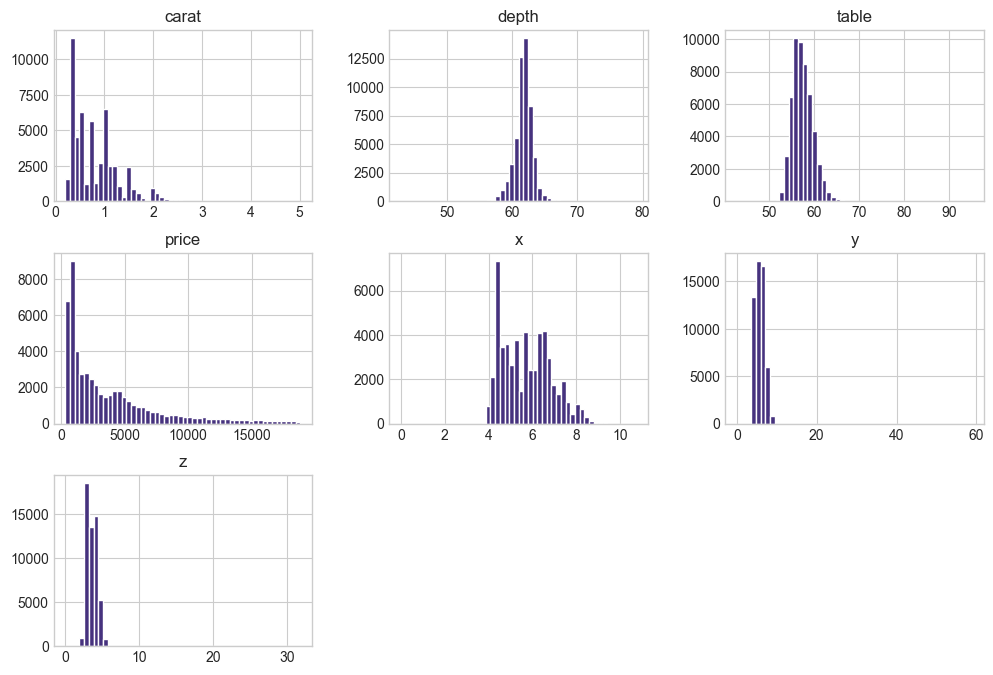

In [46]:
df.hist(bins=50, figsize=(12, 8))
plt.show()

## Automatischen Report erstellen mit ydata_profiling

In [47]:
# Report erstellen für den ersten Überblick
profile = ProfileReport(df, title="Analyse Diamond Report", explorative=True)
profile.to_file("DiamonAnalyses_ydata_profiling.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 83.37it/s]


Removed 20 rows with zero dimensions.


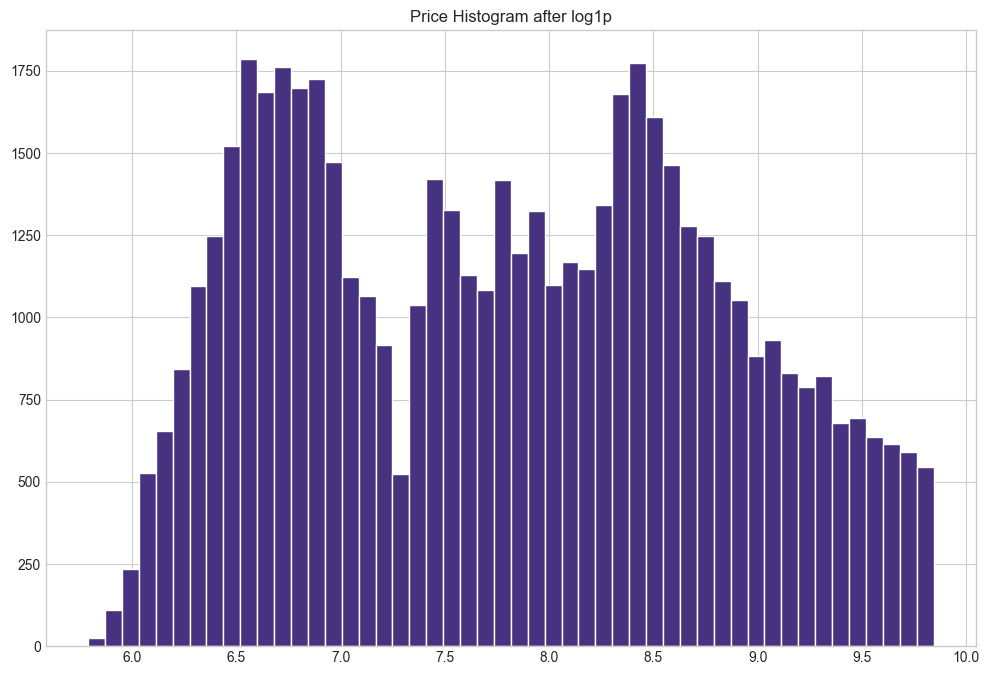

Categorical features converted to numerical using One-Hot Encoding.
New number of features: 23
Data split into 43136 training samples and 10784 testing samples.


In [48]:
# Zeilen mit einer Dimension von 0 entfernen
df_clean = df[(df[['x', 'y', 'z']] != 0).all(axis=1)].copy()
print(f"Removed {df.shape[0] - df_clean.shape[0]} rows with zero dimensions.")

# Features und Zielvariable trennen
X = df_clean.drop('price', axis=1)
y = df_clean['price']
y_log = np.log1p(y) # Aufgrund der starken linken Verteilung der Zielvarible Price

y_log.hist(bins=50, figsize=(12, 8))
plt.title('Price Histogram after log1p')
plt.show()

# One-Hot Encode Kategorien
X = pd.get_dummies(X, columns=['cut', 'color', 'clarity'], drop_first=True, dtype=float)
print("Categorical features converted to numerical using One-Hot Encoding.")
print(f"New number of features: {X.shape[1]}")

# Train-Test split erstellen
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)
print(f"Data split into {X_train.shape[0]} training samples and {X_test.shape[0]} testing samples.")

In [49]:
# --- Feature Scaling ---
# Scale numerical features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames to keep column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)
print("Features have been scaled using StandardScaler.")

Features have been scaled using StandardScaler.


## Baseline Model

In [50]:
print("\n--- Training Baseline Model (Linear Regression) ---")
baseline_model = LinearRegression()
baseline_model.fit(X_train_scaled, y_train)

# Evaluate baseline model
y_pred_baseline = baseline_model.predict(X_test_scaled)
r2_baseline = r2_score(y_test, y_pred_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)

print(f"Baseline R² Score: {r2_baseline:.4f}")
print(f"Baseline RMSE: {rmse_baseline:.4f}")
print(f"Baseline MAE: {mae_baseline:.4f}")


--- Training Baseline Model (Linear Regression) ---
Baseline R² Score: 0.9537
Baseline RMSE: 0.2181
Baseline MAE: 0.1058


## Regularized Models

In [51]:
print("\n--- Training Regularized Models ---")

# --- 5.1 Ridge Regression (L2) ---
print("Tuning Ridge (L2)...")
alphas_ridge = np.logspace(-3, 4, 50)
ridge_cv = RidgeCV(alphas=alphas_ridge, cv=5)
ridge_cv.fit(X_train_scaled, y_train)
print(f"Optimal Alpha for Ridge: {ridge_cv.alpha_:.4f}")

# --- 5.2 Lasso Regression (L1) ---
print("\nTuning Lasso (L1)...")
alphas_lasso = np.logspace(-2, 2, 50)
lasso_cv = LassoCV(alphas=alphas_lasso, cv=5, max_iter=10000, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)
print(f"Optimal Alpha for Lasso: {lasso_cv.alpha_:.4f}")

# --- 5.3 ElasticNet (L1+L2) ---
print("\nTuning ElasticNet...")
alphas_en = np.logspace(-3, 2, 50)
l1_ratios_en = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]
elastic_cv = ElasticNetCV(alphas=alphas_en, l1_ratio=l1_ratios_en, cv=5, max_iter=10000, random_state=42)
elastic_cv.fit(X_train_scaled, y_train)
print(f"Optimal Alpha for ElasticNet: {elastic_cv.alpha_:.4f}")
print(f"Optimal L1 Ratio for ElasticNet: {elastic_cv.l1_ratio_:.4f}")


--- Training Regularized Models ---
Tuning Ridge (L2)...
Optimal Alpha for Ridge: 0.0010

Tuning Lasso (L1)...
Optimal Alpha for Lasso: 0.0100

Tuning ElasticNet...
Optimal Alpha for ElasticNet: 0.0010
Optimal L1 Ratio for ElasticNet: 1.0000


## Model Comparison

In [52]:
print("\n--- Final Model Comparison ---")

models = {
    'Linear Regression': baseline_model,
    'Ridge': ridge_cv,
    'Lasso': lasso_cv,
    'ElasticNet': elastic_cv
}

results = []
for name, model in models.items():
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)

    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mae_test = mean_absolute_error(y_test, y_pred_test)

    results.append({
        'Model': name,
        'Test R²': r2_test,
        'Test RMSE': rmse_test,
        'Test MAE': mae_test,
        'Train R²': r2_train,
        'Train-Test Gap (R²)': r2_train - r2_test
    })

results_df = pd.DataFrame(results).set_index('Model')
print(results_df)


--- Final Model Comparison ---
                    Test R²  Test RMSE  Test MAE  Train R²  \
Model                                                        
Linear Regression  0.953694   0.218140  0.105758  0.981674   
Ridge              0.953694   0.218141  0.105758  0.981674   
Lasso              0.951688   0.222816  0.141792  0.963513   
ElasticNet         0.958275   0.207069  0.107103  0.981064   

                   Train-Test Gap (R²)  
Model                                   
Linear Regression             0.027980  
Ridge                         0.027980  
Lasso                         0.011825  
ElasticNet                    0.022788  


## Visualisierung


--- Generating Visualizations ---


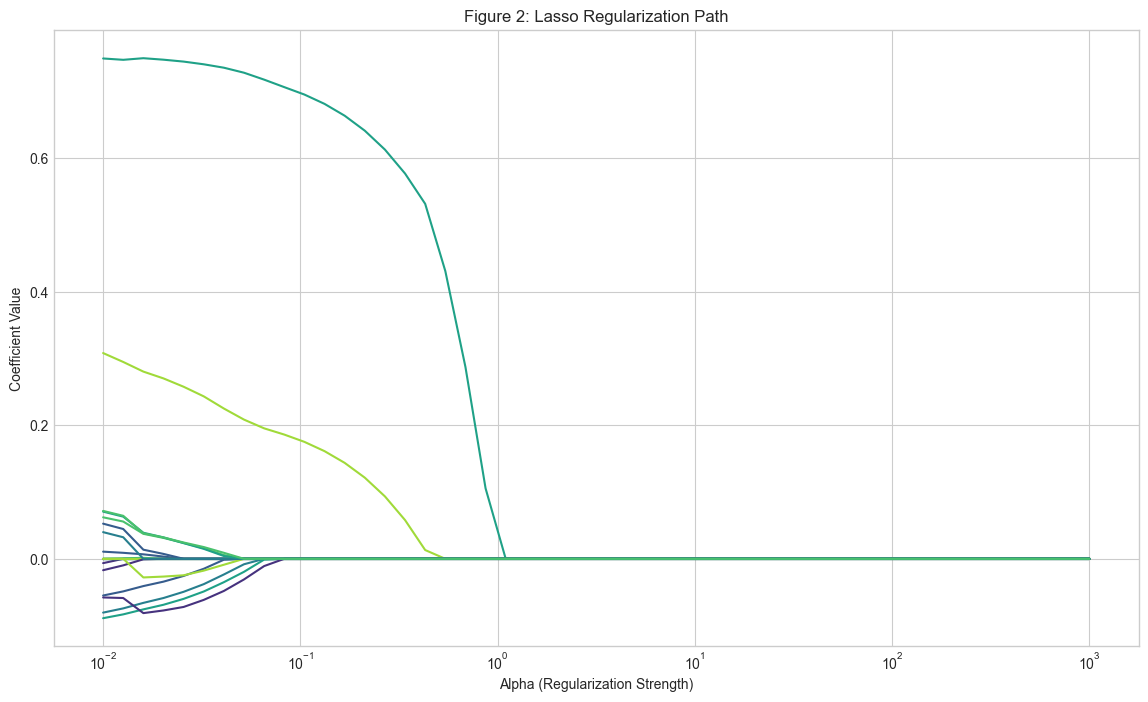

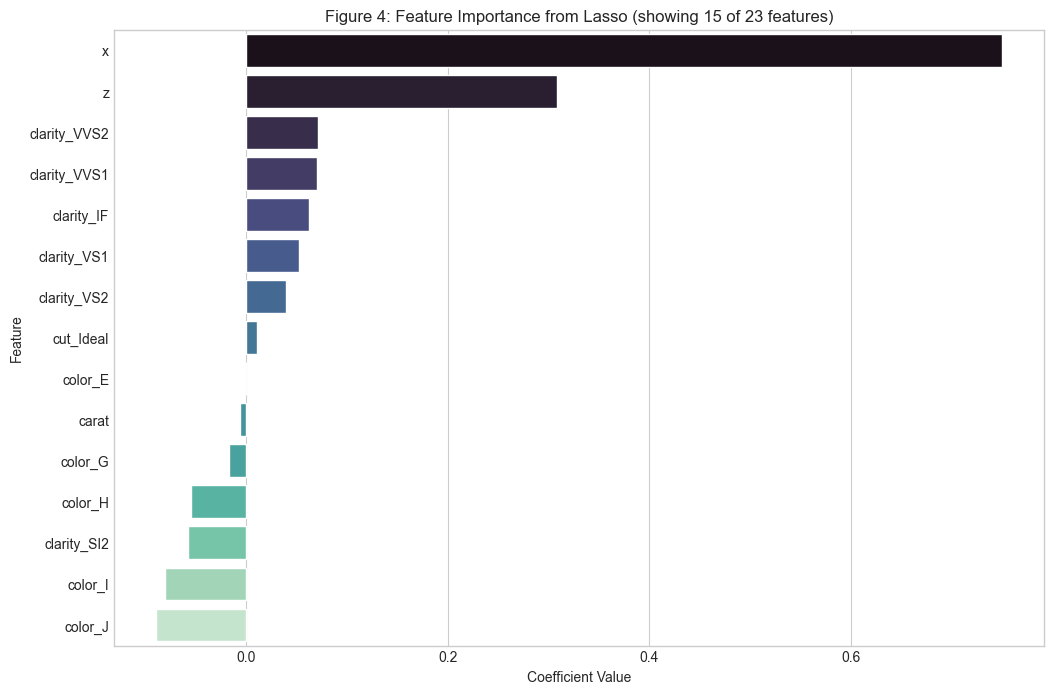

Lasso selected 15 features and eliminated 8.


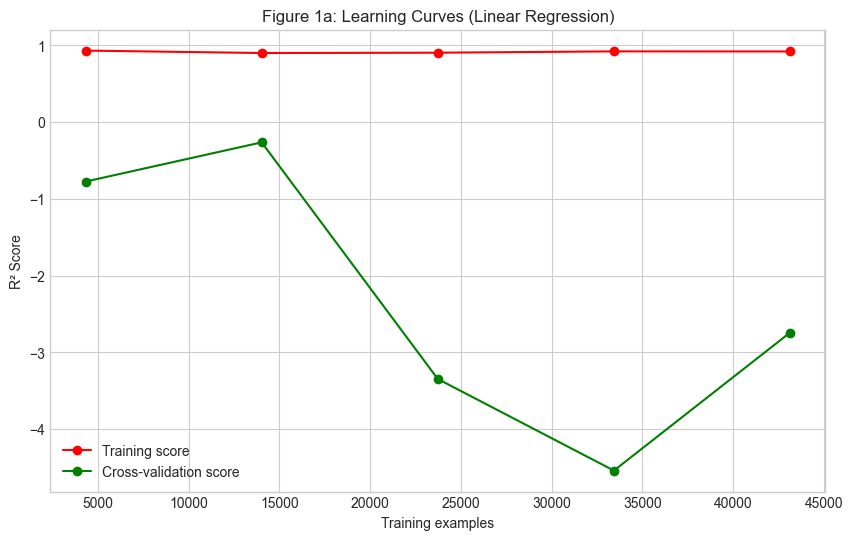

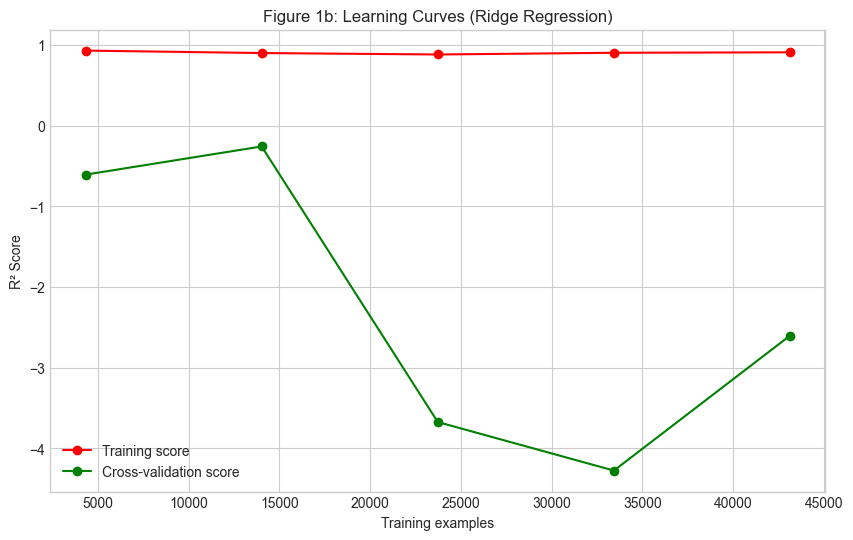

In [53]:
print("\n--- Generating Visualizations ---")

# --- 7.1 Regularization Path for Lasso ---
alphas = np.logspace(-2, 3, 50)
coefs = []
for a in alphas:
    lasso_path = Lasso(alpha=a, max_iter=5000, random_state=42) #Fehler bei max_iter=1000, aufgrund fehlender Zeit
    lasso_path.fit(X_train_scaled, y_train)
    coefs.append(lasso_path.coef_)

plt.figure(figsize=(14, 8))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Coefficient Value')
plt.title('Figure 2: Lasso Regularization Path')
plt.axis('tight')
plt.show()

# --- 7.2 Feature Importance from Lasso Model ---
lasso_coefs = pd.Series(lasso_cv.coef_, index=X.columns)
important_features = lasso_coefs[lasso_coefs != 0].sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=important_features, y=important_features.index, palette='mako', hue=important_features.index, legend=False)
plt.title(f'Figure 4: Feature Importance from Lasso (showing {len(important_features)} of {len(X.columns)} features)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()
print(f"Lasso selected {len(important_features)} features and eliminated {len(X.columns) - len(important_features)}.")

# --- 7.3 Learning Curves ---
def plot_learning_curves(estimator, title, X, y, cv=5, n_jobs=-1):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs,
        train_sizes=np.linspace(.1, 1.0, 5), scoring='r2'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("R² Score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# We use the full (unsplit) dataset for learning curves with CV
X_scaled_full = scaler.transform(X)
plot_learning_curves(baseline_model, "Figure 1a: Learning Curves (Linear Regression)", X_scaled_full, y)
plot_learning_curves(ridge_cv, "Figure 1b: Learning Curves (Ridge Regression)", X_scaled_full, y)

## Statistical Testing

In [54]:
print("\n--- Performing Statistical Significance Test (with Pipeline) ---")

# Erstelle eine Pipeline für jedes Modell
# Die Pipeline führt zuerst die Skalierung und dann das Modelltraining durch.
pipeline_ols = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

# Für Ridge verwenden wir das bereits getunte Modell (ridge_cv),
# das innerhalb der Pipeline für jeden Fold neu trainiert wird.
pipeline_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('model', ridge_cv)
])

# Führe die Kreuzvalidierung auf den Pipelines mit den unskalierten Daten durch
# WICHTIG: Wir verwenden hier die kompletten, unskalierten Daten X und y
baseline_scores = cross_val_score(pipeline_ols, X, y_log, cv=10, scoring='r2')
ridge_scores = cross_val_score(pipeline_ridge, X, y_log, cv=10, scoring='r2')

# Führe den gepaarten t-Test durch
t_statistic, p_value = stats.ttest_rel(ridge_scores, baseline_scores)

print(f"\nPaired t-test results comparing Ridge and OLS:")
print(f"Mean R² for OLS: {np.mean(baseline_scores):.4f}")
print(f"Mean R² for Ridge: {np.mean(ridge_scores):.4f}")
print(f"T-statistic: {t_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05 and np.mean(ridge_scores) > np.mean(baseline_scores):
    print("\nThe improvement from Ridge regression is statistically significant (p < 0.05).")
else:
    print("\nThe difference between the models is NOT statistically significant (p >= 0.05).")


--- Performing Statistical Significance Test (with Pipeline) ---

Paired t-test results comparing Ridge and OLS:
Mean R² for OLS: 0.8336
Mean R² for Ridge: 0.8115
T-statistic: -1.0000
P-value: 0.3434

The difference between the models is NOT statistically significant (p >= 0.05).


## Forschungsfrage: "Does regularization materially improve generalization on dataset 'Diamonds?"
Für den 'Diamons' Datensatz konnte **keine statistisch signifikante Verbesserung** durch den Einsatz von Regularisierung festgestellt werden.
Gründe dafür:
- Hohe Menge an Daten im Verhältnis zu Merkmalen. Dadurch kann die normale Lineare Regression verlässliche Koeffizienten schätzen.
- Die Beziehungen zwischen dem Preis und den Merkmalen ist sehr stark und klar.
- Regulaisierung führt künstlich einen leichten Bias ein um Overfitting zu reduzieren. Allerdings ist die Varianz bereits sehr gering, weshalb nur mehr Bias die Ergebnisse verschlechtert hat
- Lasso-Regulaisierung ist stark bei Datensätzen mit vielen irrelevanten und redundanten Merkmalen. Da in 'Diamonds' jedes Merkmal eine hohe relevanz hat könnte Lasso keine unrelevanten Merkmale entfernen